This is a test notebook for steps involved in creating an index for desired coins.  This notebook provides the building blocks for the eventual generic module that will preform this task automatically.

Scroll down to `Build Class` for production code.

In [97]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

# Importing the Data
In production this will simply call the scrape module.

In [2]:
input_dir = os.getcwd()+'\\Input' # where files from scrape module are stored

## Building Generic Class

In [150]:
class Get_Weights(object):
    
    def __init__(self,
                input_dir):
        self.input_dir = input_dir
        
    def get_coins(self):
        # iteratively read csv files
        csv_list = os.listdir(self.input_dir)
        csv_list = [k for k in csv_list if '.csv' in k]
        coins = [x.split('.')[0] for x in csv_list]
        self.coins = coins
        self.csv_list = csv_list
        
    def make_currency_dict(self):
#         build dictionary from csv list
        df_dict = {}
        for idx, i in enumerate(self.csv_list):
            df_dict.update({f'{self.coins[idx]}' : pd.read_csv(input_dir+f'\\{i}')})
        self.df_dict = df_dict
        
    
    def join_dfs(self):
        # cleaning data
        for i in range(len(self.df_dict)):
            self.df_dict[self.coins[i]].Volume = self.df_dict[self.coins[i]].Volume.replace('-', str(0))
            self.df_dict[self.coins[i]].Market_Cap = self.df_dict[self.coins[i]].Market_Cap.replace('-', str(0))
            self.df_dict[self.coins[i]].Volume = self.df_dict[self.coins[i]].Volume.apply(lambda x : str(x))
            self.df_dict[self.coins[i]].Volume = self.df_dict[self.coins[i]].Volume.apply(lambda x: x.replace(' ', ''))
            self.df_dict[self.coins[i]].Market_Cap = self.df_dict[self.coins[i]].Market_Cap.apply(lambda x : str(x))
            self.df_dict[self.coins[i]].Market_Cap = self.df_dict[self.coins[i]].Market_Cap.apply(lambda x: x.replace(' ',''))
            self.df_dict[self.coins[i]].Volume = pd.to_numeric(self.df_dict[self.coins[i]].Volume)
            self.df_dict[self.coins[i]].Market_Cap = pd.to_numeric(self.df_dict[self.coins[i]].Market_Cap)
        
        joined_df = pd.DataFrame(data = self.df_dict[self.coins[i]].Date , columns = ['Date'])
    
        for i in range(len(self.df_dict)):
            joined_df = pd.merge(joined_df, self.df_dict[self.coins[i]], on='Date', how='left')

            joined_cols_matrix = [[f'{i}_Open', f'{i}_High',
                                    f'{i}_Low', f'{i}_Close',
                                    f'{i}_Volume', f'{i}_Market_Cap'] for i in self.coins]
        joined_df.Date = pd.to_datetime(joined_df['Date'])
        joined_df.set_index(['Date'], inplace=True)
        joined_cols = []
        for sublist in joined_cols_matrix:
            for val in sublist:
                joined_cols.append(val)
        joined_df.columns = joined_cols
        joined_df.dropna(inplace=True)
        
        # adding the `Date` column back in will be helpful for dealing with non-zero mulitples for dynamicly weighting our values
        weighted_df = pd.DataFrame()
        joined_df['Date'] = joined_df.index
        joined_cols = joined_df.columns.tolist()
        joined_cols = joined_cols[-1:] + joined_cols[:-1]
        self.joined_df = joined_df[joined_cols]
        
    def get_weights(self):
        weighted_open = list()
        weighted_high = list()
        weighted_low = list()
        weighted_close = list()
        for i in range(len(self.joined_df)):
            
            # Open
            
            a = 0
            for j in range(len(self.coins)):
                open_val = self.joined_df.loc[self.joined_df.index[i],f'{self.coins[j]}_Open']
                market_cap = self.joined_df.loc[self.joined_df.index[i],f'{self.coins[j]}_Market_Cap']

                a += (open_val*market_cap)
            k = [self.joined_df.iloc[i,(k+1)*6] for k in range(len(self.coins))]

            result = a/np.sum(k)
            weighted_open.append(result)
            
            # High

            a = 0
            for j in range(len(self.coins)):
                high_val = self.joined_df.loc[self.joined_df.index[i],f'{self.coins[j]}_High']
                market_cap = self.joined_df.loc[self.joined_df.index[i],f'{self.coins[j]}_Market_Cap']

                a += (high_val*market_cap)
            k = [self.joined_df.iloc[i,(k+1)*6] for k in range(len(self.coins))]
            result = a/np.sum(k)
            weighted_high.append(result)
            
            # Low

            a = 0
            for j in range(len(self.coins)):
                low_val = self.joined_df.loc[self.joined_df.index[i],f'{self.coins[j]}_Low']
                market_cap = self.joined_df.loc[self.joined_df.index[i],f'{self.coins[j]}_Market_Cap']

                a += (low_val*market_cap)
            k = [self.joined_df.iloc[i,(k+1)*6] for k in range(len(self.coins))]
            result = a/np.sum(k)
            weighted_low.append(result)
            
            # Close

            a = 0
            for j in range(len(self.coins)):
                close_val = self.joined_df.loc[self.joined_df.index[i],f'{self.coins[j]}_Close']

                market_cap = self.joined_df.iloc[i,(j+1)*6]

                a += (close_val*market_cap)
            k = [self.joined_df.iloc[i,(k+1)*6] for k in range(len(self.coins))]
            result = a/np.sum(k)
            weighted_close.append(result)

        weighted_df = pd.DataFrame({'weighted_open':weighted_open, 
                                    'weighted_high':weighted_high, 
                                    'weighted_low':weighted_low, 
                                    'weighted_close':weighted_close}, 
                                    index=self.joined_df.index)
        # save CSV
        weighted_df.to_csv(f'{len(self.coins)}currencies_weighted_index.csv')
        # return the dataframe for exploration
        return weighted_df

In [151]:
test_run = Get_Weights(input_dir)

In [152]:
test_run.input_dir

'C:\\Users\\Mark\\Documents\\DataSci\\Module 5\\Crypto\\Input'

In [153]:
test_run.get_coins()

In [154]:
test_run.coins

['AidCoin', 'decred', 'ecobit', 'faircoin']

In [155]:
test_run.csv_list

['AidCoin.csv', 'decred.csv', 'ecobit.csv', 'faircoin.csv']

In [156]:
test_run.make_currency_dict()

In [157]:
test_run.df_dict.keys()

dict_keys(['AidCoin', 'decred', 'ecobit', 'faircoin'])

In [158]:
test_run.join_dfs()

In [159]:
test_run.joined_df.describe()

,AidCoin_Open,AidCoin_High,AidCoin_Low,AidCoin_Close,AidCoin_Volume,AidCoin_Market_Cap,decred_Open,decred_High,decred_Low,decred_Close,...,ecobit_Low,ecobit_Close,ecobit_Volume,ecobit_Market_Cap,faircoin_Open,faircoin_High,faircoin_Low,faircoin_Close,faircoin_Volume,faircoin_Market_Cap
count,613.000000,613.000000,613.000000,613.000000,6.130000e+02,6.130000e+02,613.000000,613.000000,613.000000,613.000000,...,613.000000,613.000000,613.000000,6.130000e+02,613.000000,613.000000,613.000000,613.000000,613.000000,6.130000e+02
mean,0.091265,0.097530,0.084322,0.090065,2.234883e+05,2.834791e+06,42.005889,43.793246,40.141240,41.908352,...,0.012765,0.013730,742.371941,6.102336e+06,0.208217,0.226124,0.187101,0.206747,4972.264274,1.099764e+07
std,0.103803,0.111121,0.092331,0.100414,6.641651e+05,2.313408e+06,25.297270,26.856010,23.856424,25.271255,...,0.006131,0.006854,2868.543038,3.046212e+06,0.173109,0.186759,0.155631,0.171286,15357.206514,9.111341e+06
min,0.008054,0.008653,0.007716,0.008055,6.400000e+01,0.000000e+00,14.530000,14.970000,14.210000,14.530000,...,0.002631,0.003162,0.000000,1.405269e+06,0.016271,0.016693,0.004554,0.008388,0.000000,4.461660e+05
25%,0.027464,0.031945,0.024612,0.027165,1.531600e+04,1.037741e+06,23.140000,23.530000,22.590000,23.130000,...,0.008141,0.008744,0.000000,3.886181e+06,0.067401,0.073694,0.062046,0.066960,39.000000,3.561873e+06
50%,0.054698,0.057511,0.051578,0.054596,4.862100e+04,2.309185e+06,31.920000,33.540000,30.150000,31.680000,...,0.012290,0.012969,28.000000,5.764044e+06,0.123771,0.133577,0.116666,0.123276,422.000000,6.557523e+06
75%,0.116413,0.121233,0.110559,0.116309,1.916540e+05,4.193674e+06,59.040000,61.570000,55.910000,58.800000,...,0.015777,0.016923,237.000000,7.521156e+06,0.332119,0.363050,0.274438,0.331296,2301.000000,1.762290e+07
max,0.808118,0.827591,0.670572,0.803381,1.081590e+07,1.119565e+07,116.780000,139.940000,108.680000,116.790000,...,0.033828,0.043110,44692.000000,1.915987e+07,0.832744,0.857181,0.799262,0.819353,172951.000000,4.358452e+07


In [160]:
weights_only = test_run.get_weights()

In [149]:
weights_only.iloc[0,0:4]

weighted_open     17.219349
weighted_high     17.406729
weighted_low      16.805047
weighted_close    17.022020
Name: 2019-10-02 00:00:00, dtype: float64

In [148]:
weights_only.iloc[0,0]

17.21934888763718

# Exploring with Visualizations

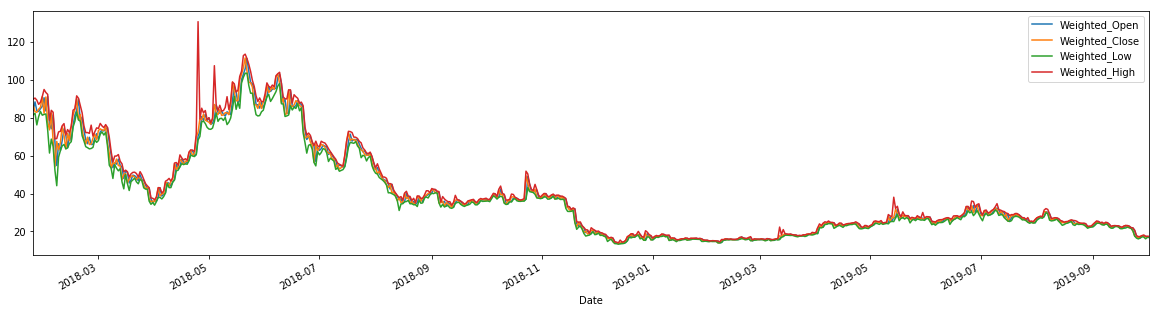

In [37]:
weights_only = final_df.loc[:,['Weighted_Open', 'Weighted_Close',
       'Weighted_Low', 'Weighted_High']]
weights_only.plot(figsize=(20,5));

In [142]:
decimals = weights_only.round(4)

In [143]:
decimals.head(2)

,weighted_open,weighted_high,weighted_low,weighted_close
Date,,,,
2019-10-02,17.2193,17.4067,16.8050,17.0220
2019-10-01,17.0461,17.4955,16.8409,17.0464


In [56]:
weights_only['Date'] = [mdates.date2num(d) for d in weights_only.index]
quotes = [tuple(x) for x in weights_only[['Date', 'Weighted_Open','Weighted_Close','Weighted_Low','Weighted_High']].values]
quotes[:5]

[(736718.0,
  83.97937376323927,
  86.52187252407899,
  81.65470256356834,
  89.91654082962188),
 (736719.0,
  88.46885572893339,
  83.29935510798539,
  82.45774100878351,
  90.50007258716983),
 (736720.0,
  83.81612604329115,
  82.98058846770518,
  76.30349385310309,
  89.36286060335092),
 (736721.0,
  83.40169506363802,
  84.58690694390864,
  80.67496221016815,
  87.15791498728092),
 (736722.0,
  84.87460410507202,
  85.60959730520189,
  83.43396052783824,
  88.3189248338217)]

### Plot a Candlestick Chart

In [42]:

from mpl_finance import candlestick_ohlc
 
import matplotlib
matplotlib.use('Agg') # Bypass the need to install Tkinter GUI framework
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
 
# Avoid FutureWarning: Pandas will require you to explicitly register matplotlib converters.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
 

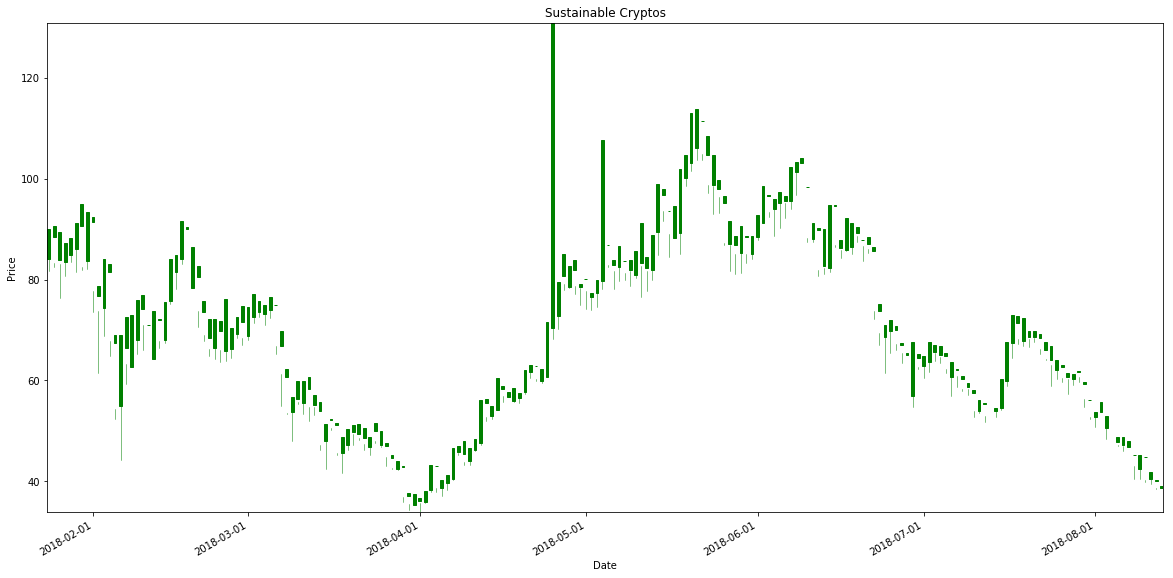

In [63]:
# Plot candlestick.
##########################
fig, ax = plt.subplots(figsize=(20,10))
candlestick_ohlc(ax, quotes[:200], width=0.5, colorup='g', colordown='r');

 
# Customize graph.
##########################
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Sustainable Cryptos')
 
# Format time.
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
 
plt.gcf().autofmt_xdate()   # Beautify the x-labels
plt.autoscale(tight=True)
 
# Save graph to file.
plt.savefig('sustainable_cryptos.png')

In [93]:
weights_only.to_csv('first_index.csv', sep='\t', encoding='utf-8')

I think I want to mean average these for the index weighted by volume and market cap of each coin.

# Display various Index Measures for Evaluation

Text(0.5, 1.0, 'Raw Data')

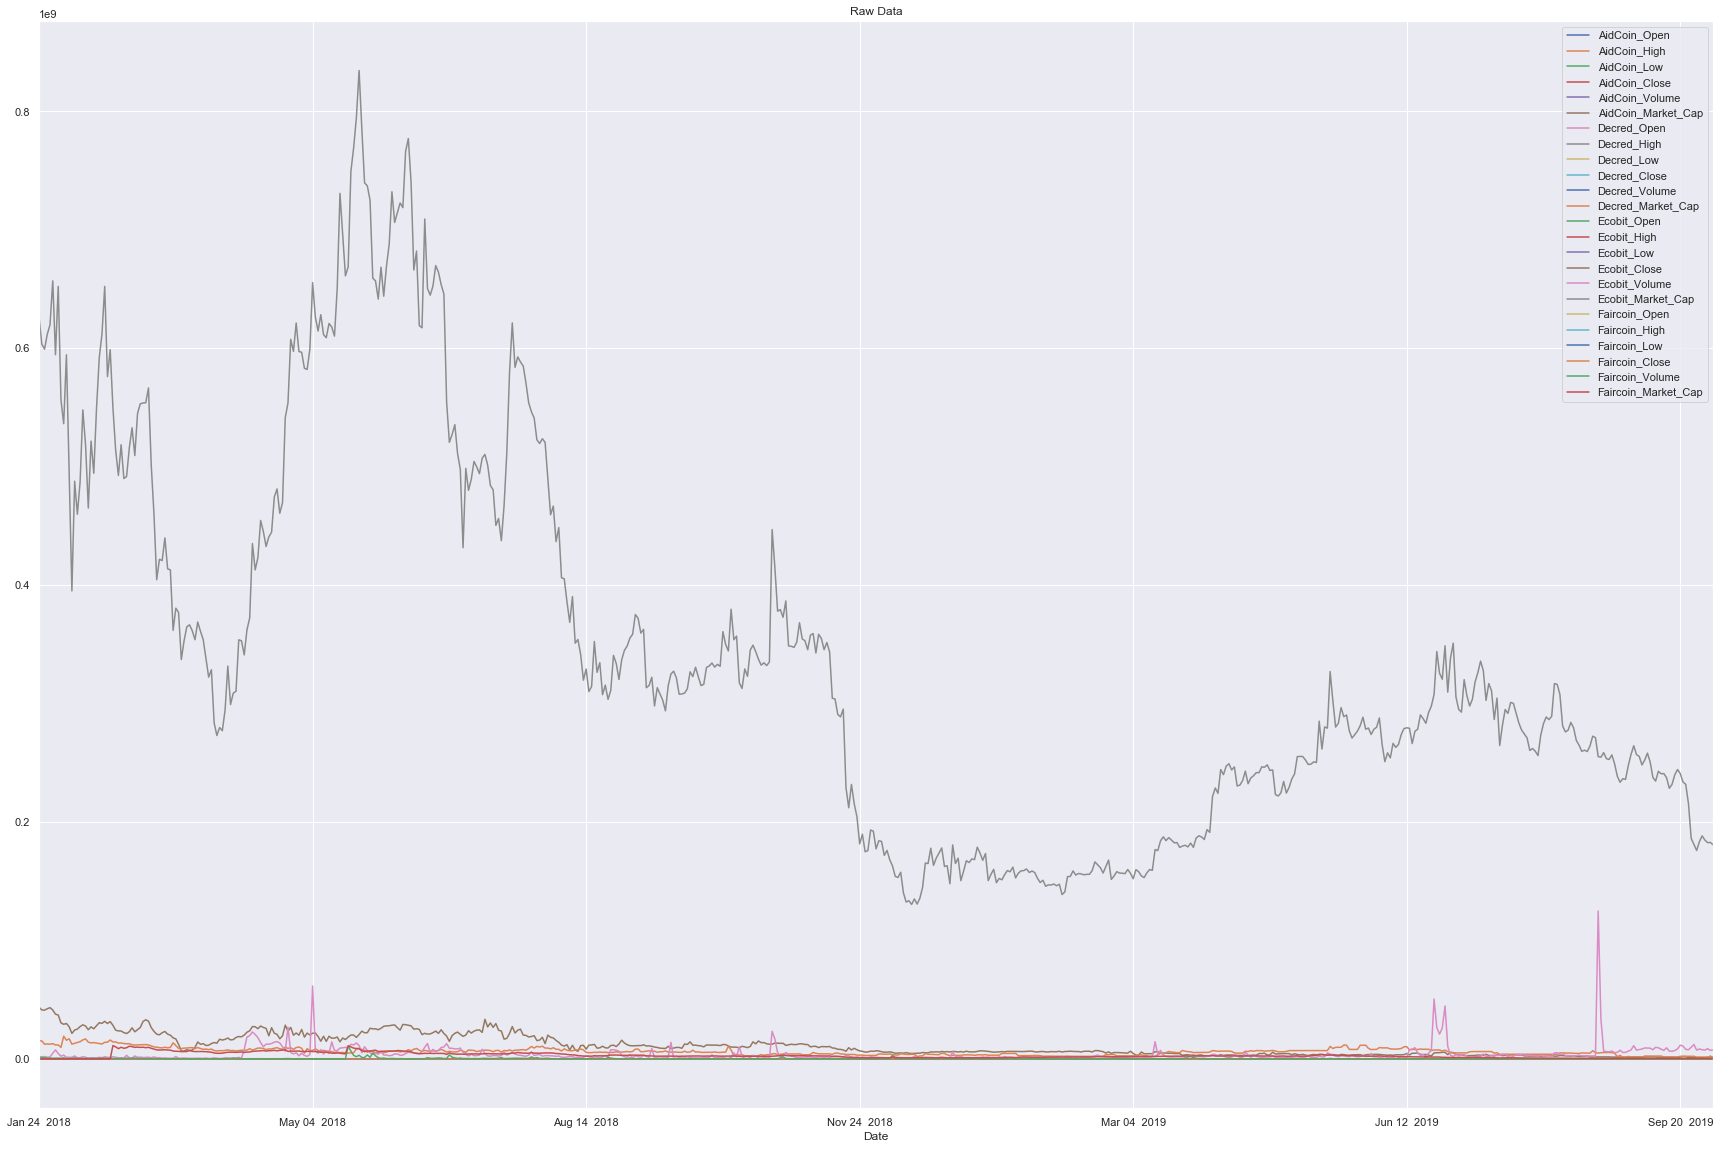

In [161]:
final_df.loc[:, :'Faircoin_Market_Cap'].plot(figsize=(30,20))
plt.title('Raw Data')

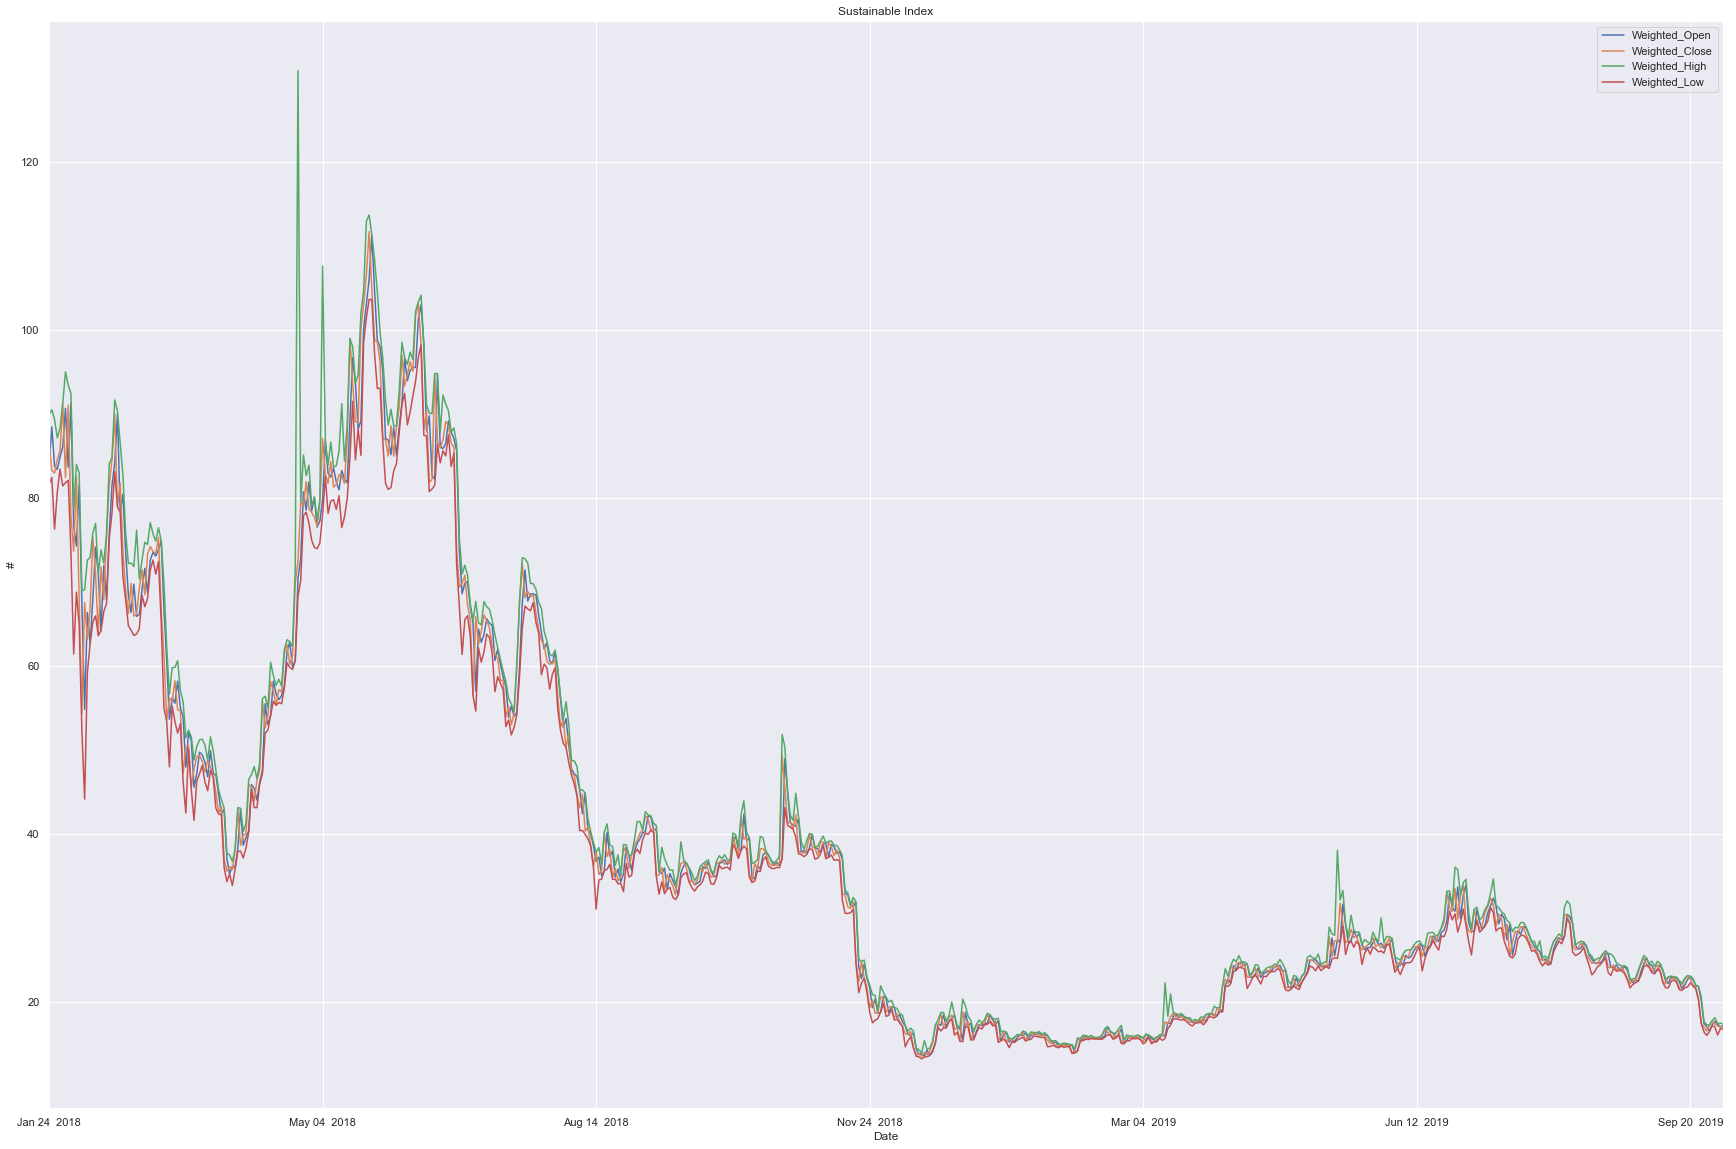

In [157]:
feat = final_df.loc[:, 'Weighted_Open':'Weighted_Low']
feat.plot(figsize=(30,20));
plt.title('Sustainable Index')
plt.ylabel('#')
plt.savefig('weighted_no_memory.png')

In [160]:
open_cols = [col for col in final_df.columns if 'Open' in col]
opens = final_df[open_cols]
high_cols = [col for col in final_df.columns if 'High' in col]
highs = final_df[high_cols]
low_cols = [col for col in final_df.columns if 'Low' in col]
lows = final_df[low_cols]
close_cols = [col for col in final_df.columns if 'Close' in col]
closes = final_df[close_cols]

In [162]:
opens['Average'] = opens.mean(axis=1)

C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [163]:
opens.head()

,AidCoin_Open,Decred_Open,Ecobit_Open,Faircoin_Open,Weighted_Open,Average
Date,,,,,,
Jan 24 2018,0.809443,0.033615,91.79,0.730442,83.979374,35.468575
Jan 25 2018,0.832744,0.034505,96.70,0.808118,88.468856,37.368845
Jan 26 2018,0.774731,0.034199,91.25,0.644342,83.816126,35.303880
Jan 27 2018,0.773636,0.025812,90.83,0.573812,83.401695,35.120991
Jan 28 2018,0.799262,0.028558,92.44,0.623214,84.874604,35.753128


In [164]:
highs['Average'] = highs.mean(axis=1)
lows['Average'] = lows.mean(axis=1)
closes['Average'] = closes.mean(axis=1)

C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [169]:
#halflife is set to 1 day
opens['exp_rolmean'] = opens['Average'].ewm(halflife=1).mean()

C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


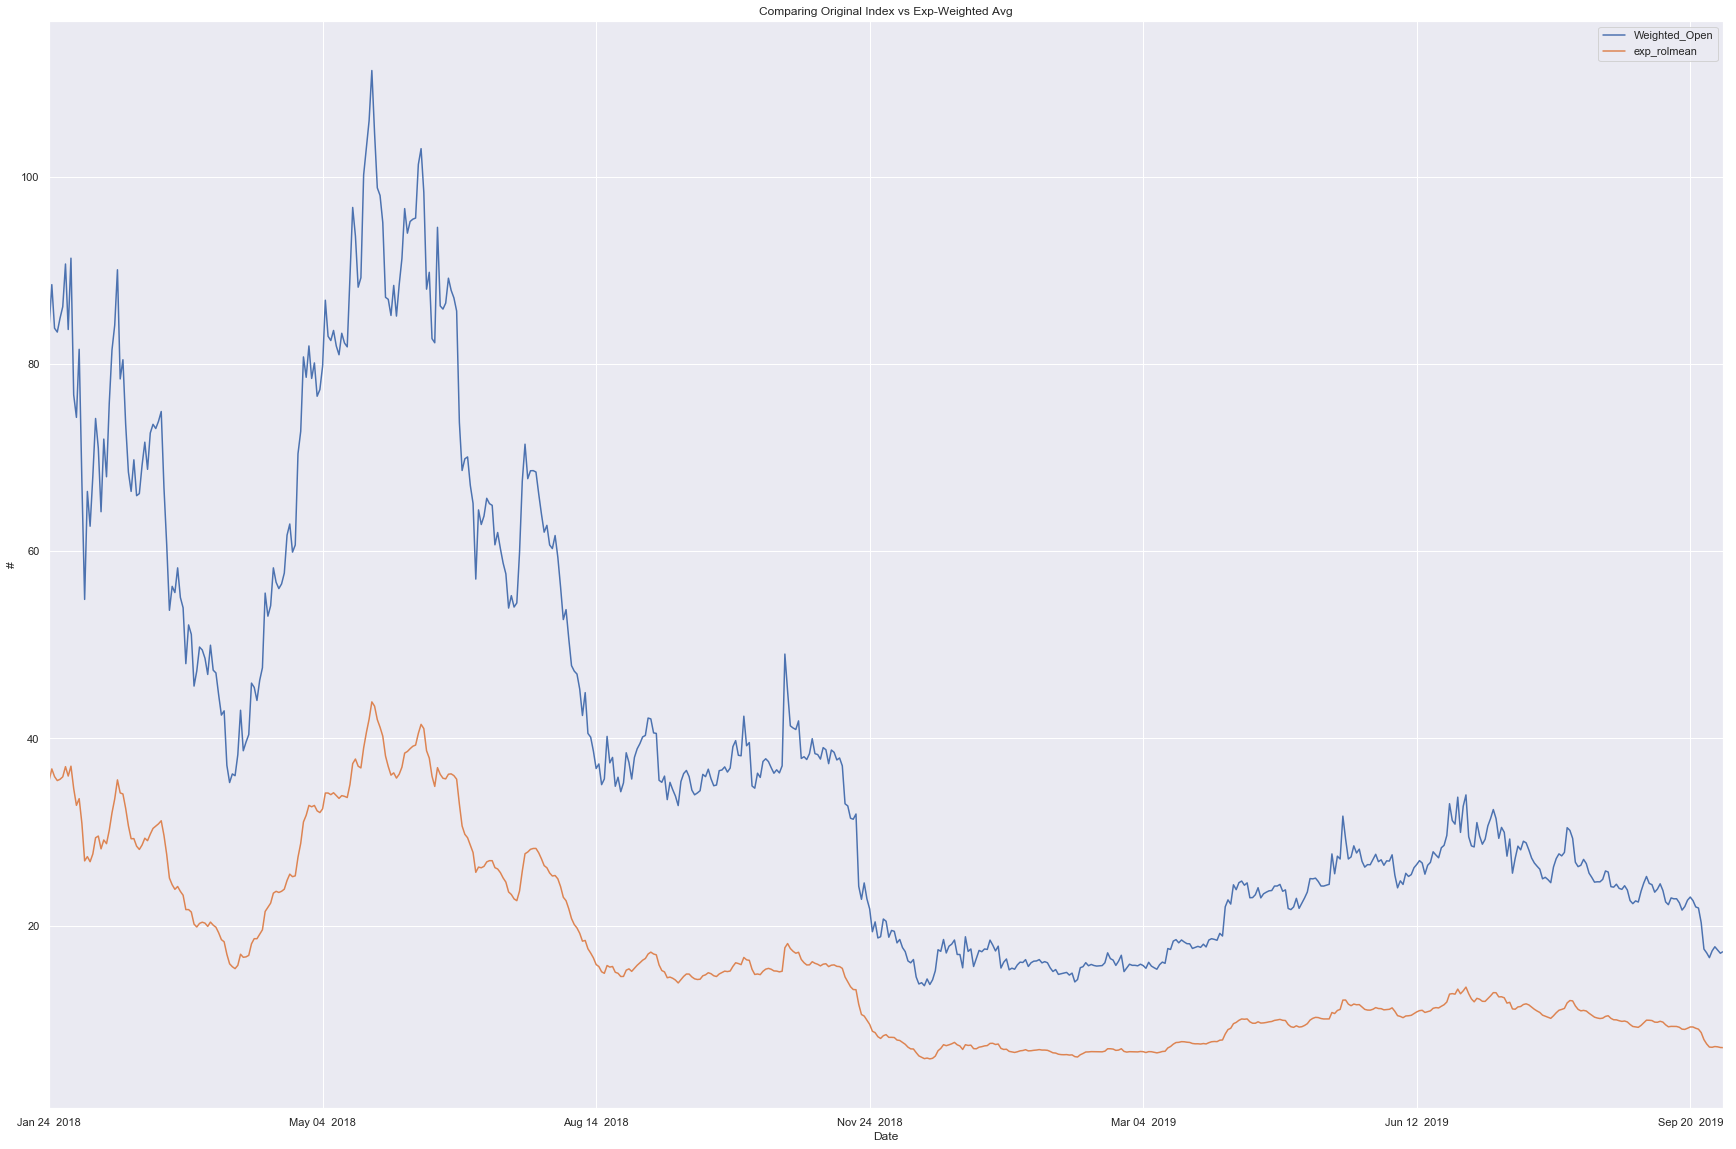

In [219]:
# It should be noted that this weighted average takes the previously summed weight (which it compares against) in as a feature

opens[['Weighted_Open', 'exp_rolmean']].plot(figsize=(30,20))
plt.title('Comparing Original Index vs Exp-Weighted Avg')
plt.ylabel('#')
plt.savefig('Comparing_Summed_vs_exp_weighted_mean.png')

In [174]:
from fbprophet import Prophet as proph

In [207]:
Model = proph(interval_width=0.95)
ds = pd.DataFrame()
ds['y'] = opens['exp_rolmean']
ds['ds'] = opens.index

ds['ds'] = pd.to_datetime(ds['ds'])

In [208]:
ds.head()

,y,ds
Date,,
Jan 24 2018,35.468575,2018-01-24
Jan 25 2018,36.735421,2018-01-25
Jan 26 2018,35.917397,2018-01-26
Jan 27 2018,35.492647,2018-01-27
Jan 28 2018,35.627089,2018-01-28


In [209]:
Model.fit(ds)

C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\site-packages\fbprophet\forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [215]:
#Predict one month in the future
future_dates = Model.make_future_dataframe(periods=30, include_history = True)
future_dates.tail()

,ds
638,2019-10-28
639,2019-10-29
640,2019-10-30
641,2019-10-31
642,2019-11-01


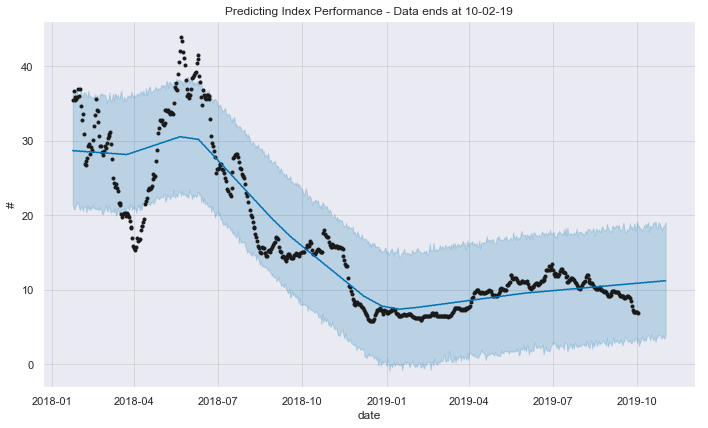

In [218]:
forecast = Model.predict(future_dates)
Model.plot(forecast, uncertainty=True)
plt.ylabel('#')
plt.xlabel('date')
plt.title('Predicting Index Performance - Data ends at 10-02-19')
plt.savefig('Predicting_Performance.png')
plt.show();